In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes

In [2]:
model_n = 0
# task_list = ['dmcgo','dmcnogo']
task_list = ['fdgo','fdanti','delaygo','delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = 'all_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

# m = os.path.join(p,'data/rnn/multitask/','robert',str(model_n))

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','clusters_overview')
if not os.path.exists(figpath):
    os.makedirs(figpath)

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


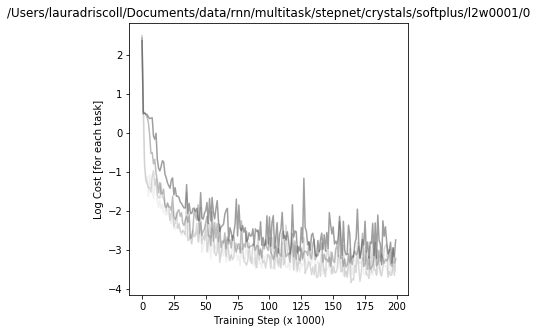

In [3]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [4]:
from network import get_perf
from task import generate_trials
from tools_lnd import get_T_inds
from numpy import linalg as LA

def get_h_diff(model_dir, task_list, lesion_units_list, d = []):

    model = FixedPoint_Model(model_dir)
    hp = model.hp

    h_diff = {}
    h_diff_norm = {}
    h_error_labels = {}
    h_error = {}

    for ri in range(len(task_list)):
        rule = task_list[ri]

        trial = generate_trials(rule, hp, 'test', noise_on = 'False')

        _,h = gen_X_from_model_dir(model_dir,trial,d = d,lesion_units_list = [])
        _,h_lesion = gen_X_from_model_dir(model_dir,trial,d = d,lesion_units_list = lesion_units_list)

        h_diff[rule] = h - h_lesion
        h_diff_norm[rule] = LA.norm(h_diff[rule],axis = 0)

        h_error_labels[rule] = trial.epochs.keys()
        h_error[rule] = np.empty(len(trial.epochs.keys()))

        for ei in range(len(trial.epochs.keys())):
            epoch = trial.epochs.keys()[ei]
            T_inds = get_T_inds(trial,epoch)
            h_error[rule][ei] = np.mean(h_diff_norm[rule][:,T_inds].flatten())

    return h_diff, h_diff_norm, h_error_labels, h_error

def vis_h_diff(model_dir, task_list, h_diff):
    
    model = FixedPoint_Model(model_dir)
    hp = model.hp
    
    nc = 3
    fig = plt.figure(figsize=(nc*4,len(task_list)),tight_layout=True,facecolor='white')
    for ri in range(len(task_list)):
        rule = task_list[ri]
        trial = generate_trials(rule, hp, 'test', noise_on = 'False')

        ax = plt.subplot(int(np.ceil(len(task_list)/nc)),nc,ri+1)

        subselect_trials = h_diff[rule][:,npr.permutation(h_diff[rule].shape[1])[:80],:]
        plt.plot(LA.norm(subselect_trials,axis = 0).T,c = c,alpha = .1)

        for epoch in trial.epochs.keys():
            T_inds = get_T_inds(trial,epoch) 
            plt.plot([T_inds[-1],T_inds[-1]],[0,5],'dodgerblue',alpha = .5)

        plt.title(rule)
        plt.ylim([0,12])


def vis_h_diff_learning(model_dir, task_list, h_diff, c='k'):
    
    model = FixedPoint_Model(m)
    hp = model.hp

    nc = 3
    fig = plt.figure(figsize=(nc*4,len(task_list)),tight_layout=True,facecolor='white')
    for ri in range(len(task_list)):
        rule = task_list[ri]
        trial = generate_trials(rule, hp, 'test', noise_on = 'False')

        ax = plt.subplot(int(np.ceil(len(task_list)/nc)),nc,ri+1)

    #     subselect_trials = h_diff[rule][:,npr.permutation(h_diff[rule].shape[1])[:80],:]
        mean_trials = np.mean(h_diff[rule],axis = 1)
        plt.plot(LA.norm(mean_trials,axis = 0),c = c,alpha = .8,linewidth = 3)

        for epoch in trial.epochs.keys():
            T_inds = get_T_inds(trial,epoch) 
            plt.plot([T_inds[-1],T_inds[-1]],[0,5],'dodgerblue',alpha = .5)

        plt.title(rule)
        plt.ylim([0,5])

In [5]:
variance.compute_variance(m)
save_name = '_'+file_spec+'_'+str(model_n)
CA = clustering.Analysis(m, data_type='epoch')
CA.plot_variance(save_name = save_name)
CA.plot_2Dvisualization('tSNE')

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
[u'fdgo', u'reactgo', u'delaygo', u'fdanti', u'reactanti', u'delayanti', u'delaydm1', u'delaydm2', u'contextdelaydm1', u'contextdelaydm2', u'multidelaydm', u'dmsgo', u'dmsnogo', u'dmcgo', u'dmcnogo']
Variance saved at /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/variance_rule.pkl
V

ValueError: No hp found for model_dir /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/ckpts

In [6]:
CA = clustering.Analysis(m, data_type='epoch')

Choosing 18 clusters


In [8]:
perfs_changes, cost_changes = CA.lesions()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

In [7]:
lesion_units_list = [None]
for il, l in enumerate(CA.unique_labels):
    ind_l = np.where(CA.labels == l)[0]
    # In original indices
    lesion_units_list += [CA.ind_active[ind_l]]

for i, lesion_units in enumerate(lesion_units_list):
    print(i)
    print(lesion_units)
    

0
None
1
[113 224  66 123 102 172]
2
[60 52 76 79]
3
[109 168  69 141]
4
[183 153 132  48 164  33  73]
5
[ 63 160  23  85 237 246]
6
[ 90  75 124 217  30]
7
[ 59 145 155]
8
[ 24 243 222  14  17 180 204 116  37 167 198 171]
9
[214 166 215  38 186   9   8  50  35 117]
10
[219   1   2   6  55   4]
11
[207 100 179 144  98]
12
[ 62 200 128 131  20]
13
[ 97 255 115  99 193  77 150]
14
[161]
15
[134 130  49 210 133 136  28 138  12 105 139 226]
16
[202 126  41 187 238   7 162 181  89  74  64 223  68 140]
17
[230 218  15  67  71  78 148 216]
18
[ 19 185 173 170 225  88 154 147 121 118]


In [ ]:
# epoch = 'stim1'
# f = os.path.join(m,'tf_fixed_pts_all_init','fdanti',epoch+'_'+str(324)+'.0.npz')
# D_use,_,_ = make_FP_axs(f,m,'fdanti',epoch,axs ='pca', clust = 'False')
# axes_label1 = 'fp pca_1'
# axes_label2 = 'fp pca_2'
# axes_label3 = 'fp pca_3'

In [12]:
model = Model(m, sigma_rec=0)
with tf.Session() as sess:
    model.restore()
    hp = model.hp

###ANTI CLUSTER FOR NOW
cluster=5
save_dir = os.path.join(figpath,'lesion '+str(cluster))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


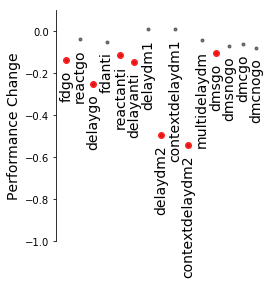

In [13]:
fig = plt.figure(figsize=(7,7),tight_layout=True,facecolor='white')
ax = plt.subplot(2,2,1)
perfs_change_cluster = perfs_changes[cluster,:]
plt.plot(perfs_change_cluster,'.k',alpha = .5)
# plt.plot([0,len(perfs_change_cluster)],[-.5,-.5],':k',alpha = .3)
tasks_affected = np.where(perfs_changes[cluster,:]<-.1)[0]
if len(tasks_affected)>0:
    plt.plot(tasks_affected,perfs_change_cluster[tasks_affected],'or',alpha = .8)
task_list = [hp['rule_trains'][x] for x in tasks_affected]
for x in range(len(hp['rule_trains'])):
    plt.text(x-.5,perfs_change_cluster[x]-.1,hp['rule_trains'][x],rotation = 90,fontsize = 14)
plt.ylabel('Performance Change',fontsize = 14)
# plt.xlabel('Tasks',fontsize = 14)
plt.ylim([-1,.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

figname = 'perf_change'
plt.savefig(os.path.join(save_dir,figname+'.pdf'))
plt.savefig(os.path.join(save_dir,figname+'.png'))

In [9]:
from tools_lnd import gen_X_from_model_dir
model = FixedPoint_Model(CA.model_dir)
hp = model.hp

# lesion cluster
ind_l = np.where(CA.labels == cluster)[0]
lesion_units_list = [CA.ind_active[ind_l]][0]

rule_train = hp['rule_trains']
h_diff, h_diff_norm, h_error_labels, h_error = get_h_diff(CA.model_dir, rule_train, lesion_units_list)

Overwrite sigma_rec with 0.000
0.0
Overwrite sigma_rec with 0.000
0.0
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

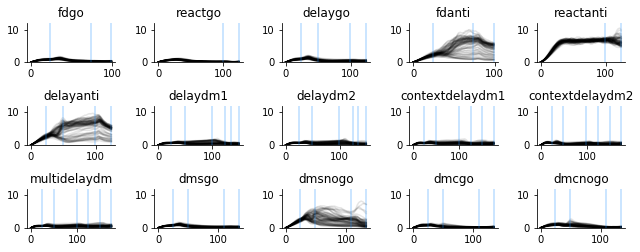

In [10]:
nc = 5
nr = int(np.ceil(len(rule_train)/nc))
fig = plt.figure(figsize=(nc*1.8,nr*1.2),tight_layout=True,facecolor='white')
for ri in range(len(rule_train)):
    rule = rule_train[ri]
    trial = generate_trials(rule, hp, 'test', noise_on = 'False')

    ax = plt.subplot(nr,nc,ri+1)

    subselect_trials = h_diff[rule][:,npr.permutation(h_diff[rule].shape[1])[:80],:]
    plt.plot(LA.norm(subselect_trials,axis = 0).T,c = 'k',alpha = .1)

    for epoch in trial.epochs.keys():
        T_inds = get_T_inds(trial,epoch) 
        plt.plot([T_inds[-1],T_inds[-1]],[0,12],'dodgerblue',alpha = .3)

    plt.title(rule)
    plt.ylim([0,12])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
figname = 'h_diff'
plt.savefig(os.path.join(save_dir,figname+'.pdf'))
plt.savefig(os.path.join(save_dir,figname+'.png'))

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


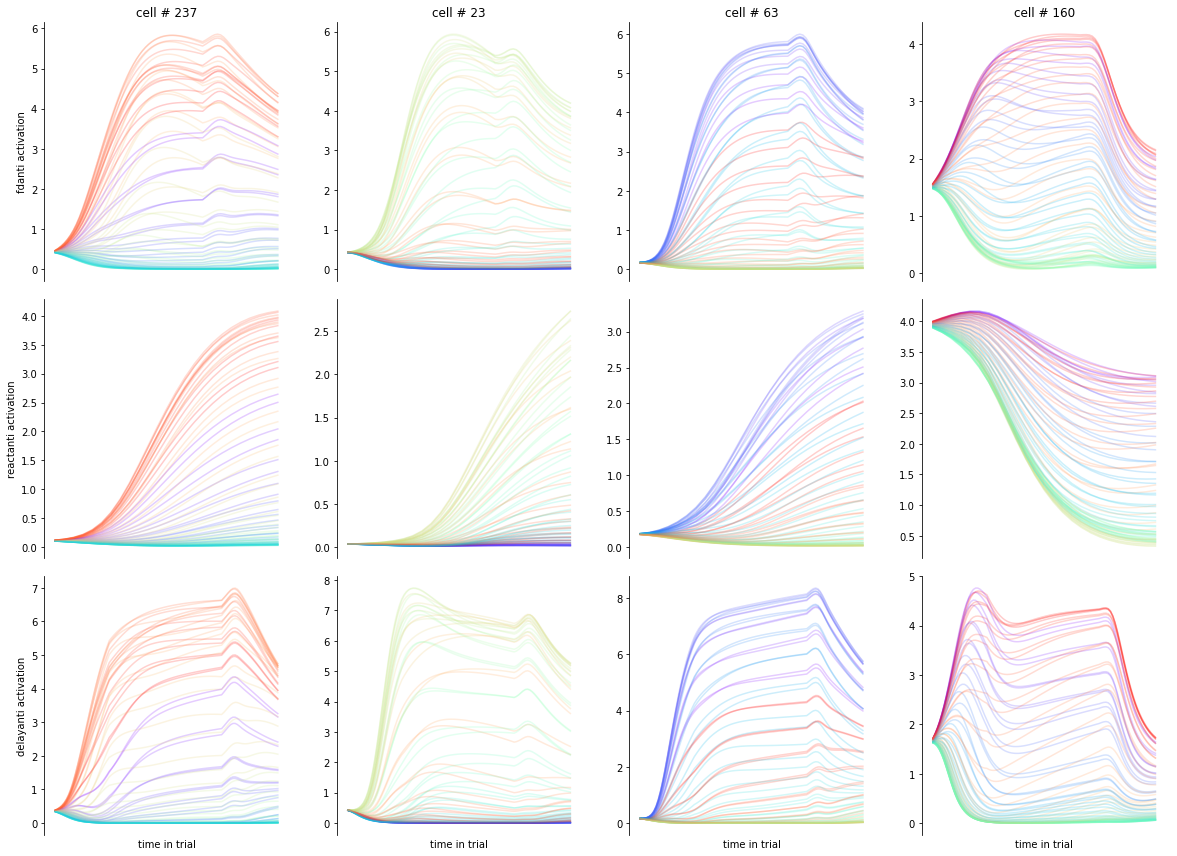

In [19]:
cmap = plt.get_cmap('rainbow')

cel_use = CA.ind_active[CA.labels==cluster]
n_trials = 80
n_trials_large = 3200
trial_order_large = npr.permutation(n_trials_large)

_, h_all_byrule = make_h_all(m)

if len(cel_use)>4:
    subplot_width = len(cel_use)
    subplot_correction = 0
else:
    subplot_width = 5
    subplot_correction = subplot_width-len(cel_use)

fig = plt.figure(figsize=(4*subplot_width,4*len(task_list)),tight_layout=True,facecolor='white')

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = generate_trials(rule, hp, 'test', noise_on=False)
    X_use = h_all_byrule[rule]
    trial_order = trial_order_large[trial_order_large<np.shape(X_use)[1]][:n_trials]

    cel_i = 0
    for unit_i in cel_use:
        cel_i+=1
        ax = plt.subplot(len(task_list),subplot_width,cel_i+subplot_width*ri+subplot_correction)
        c_inds = trial.y_loc[-1,trial_order]/np.max(trial.y_loc[-1,:])
        X_flat = np.reshape(X_use[:,trial_order,:],(-1,hp['n_rnn']))
        for n in range(n_trials):
            plt.plot(X_flat[range(n,len(X_flat),n_trials),unit_i],'-',c = cmap(c_inds[n]),alpha = .2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        if rule==task_list[0]:
            plt.title('cell # '+(str(unit_i)))
        if rule==task_list[-1]:
            plt.xlabel('time in trial')
        if cel_i==1:
            plt.ylabel(rule+' activation')

figname = 'single_unit_activations'
plt.savefig(os.path.join(save_dir,figname+'.pdf'))

In [20]:
print(os.path.join(save_dir,figname+'.pdf'))

/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/clusters_overview/lesion 6/single_unit_activations.pdf


In [21]:
from tools_lnd import make_h_all
from sklearn.decomposition import PCA
X_use = []
n_components = 5

D_pca = {}
for rule in task_list:
    trial_order = npr.permutation(n_trials)
    X_rule = h_all_byrule[rule]
    X_flat = np.reshape(X_rule[:,trial_order,:],(-1,hp['n_rnn']))
    if len(X_use)==0:
        X_use = X_flat
    else:
        X_use = np.concatenate((X_use,X_flat),axis = 0)

pca = PCA(n_components = n_components)
fp_pca = pca.fit_transform(X_use)
D_pca['axes'] = pca.components_.T
D_pca['labels'] = ['pca_'+str(x+1) for x in range(n_components)]

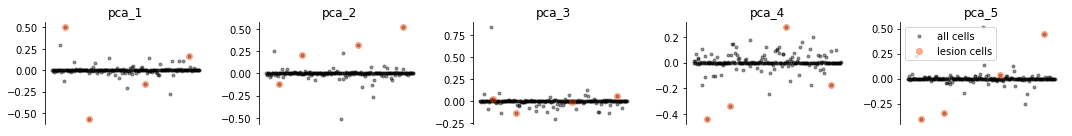

In [23]:
cels = CA.ind_active[CA.labels==cluster]

fig = plt.figure(figsize=(3*n_components,2),tight_layout=True,facecolor='white')

for x in range(n_components):

    ax = plt.subplot(1,n_components,x+1)
    plt.plot(D_pca['axes'][:,x],'.k',label = 'all cells',alpha = .4)
    plt.plot(cels,D_pca['axes'][cels,x],'o',color = 'orangered',label = 'lesion cells',alpha = .4)
    plt.title(D_pca['labels'][x])
    if x==n_components-1:
        plt.legend()
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    
    tit = 'pc_contribution'
    figname = os.path.join(tit+'_'+rule)
    plt.savefig(os.path.join(save_dir,figname+'.pdf'))
    plt.savefig(os.path.join(save_dir,figname+'.png'))

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

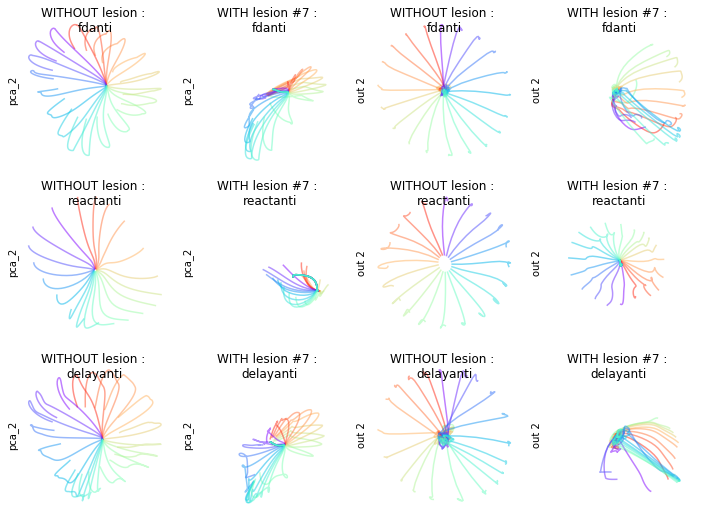

In [24]:
from network import get_perf
from task import generate_trials

# lesion cluster
ind_l = np.where(CA.labels == cluster)[0]
lesion_units_list = [CA.ind_active[ind_l]][0]

from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(m)

D_out = {}
D_out['axes'] = w_out[:,1:]
D_out['labels'] = ['W_{out} cos(theta)','W_{out} sin(theta)']

D_use = D_out['axes']
axes_labels = D_out['labels']

D_use = D_pca['axes']
axes_labels = D_pca['labels']

cmap = plt.get_cmap('rainbow')

fig = plt.figure(figsize=(12, 3*len(task_list)))
model = Model(CA.model_dir)
hp = model.hp
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    if len(lesion_units_list)>0:
        model.lesion_units(sess, lesion_units_list)

    for ri in range(len(task_list)):
        rule = task_list[ri]
        trial = generate_trials(rule, hp, 'test', noise_on = False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf = sess.run([model.h], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

        for trial_i in range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/20)):
            c = cmap(trial.y_loc[-1,trial_i]/(2*np.pi))
            
            ax = plt.subplot(len(task_list),4,1+(4*ri))
            X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_pca['axes'])
            plt.plot(X_rule[:,0],X_rule[:,1],c = c,alpha = .5)
            if ri==len(task_list):
                plt.xlabel(axes_labels[0])
            plt.ylabel(axes_labels[1])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)  
            ax.set_xticks([]) 
            ax.set_yticks([])
            plt.title('WITHOUT lesion : \n'+rule, y=1.0, pad=-14)
            ylims = ax.get_ylim()
            xlims = ax.get_xlim()
            
            ax = plt.subplot(len(task_list),4,2+(4*ri))
            X_dot = np.dot(h_tf[0][:,trial_i,:],D_pca['axes'])
            plt.plot(X_dot[:,0],X_dot[:,1],c = c,alpha = .5)
            plt.xlim(xlims)
            plt.ylim(ylims)
            if ri==len(task_list):
                plt.xlabel(axes_labels[0])
            plt.ylabel(axes_labels[1])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)  
            ax.set_xticks([]) 
            ax.set_yticks([])
            plt.title('WITH lesion #'+str(cluster+1)+' : \n'+rule, y=1.0, pad=-14)
            
            ax = plt.subplot(len(task_list),4,3+(4*ri))
            X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_out['axes'])
            plt.plot(X_rule[:,0],X_rule[:,1],c = c,alpha = .5)
            if ri==len(task_list):
                plt.xlabel('out 1')
            plt.ylabel('out 2')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)  
            ax.set_xticks([]) 
            ax.set_yticks([])
            plt.title('WITHOUT lesion : \n'+rule, y=1.0, pad=-14)
            ylims = ax.get_ylim()
            xlims = ax.get_xlim()
            
            ax = plt.subplot(len(task_list),4,4+(4*ri))
            X_dot = np.dot(h_tf[0][:,trial_i,:],D_out['axes'])
            plt.plot(X_dot[:,0],X_dot[:,1],c = c,alpha = .5)
            plt.xlim(xlims)
            plt.ylim(ylims)
            if ri==len(task_list):
                plt.xlabel('out 1')
            plt.ylabel('out 2')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False) 
            ax.set_xticks([]) 
            ax.set_yticks([])
            plt.title('WITH lesion #'+str(cluster+1)+' : \n'+rule, y=1.0, pad=-14)
            
        figname = 'population_compare'
        plt.savefig(os.path.join(save_dir,figname+'.pdf'))
        plt.savefig(os.path.join(save_dir,figname+'.png'))

In [11]:
from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(m)

D_out = {}
D_out['axes'] = w_out[:,1:]
D_out['labels'] = ['W_{out} cos(theta)','W_{out} sin(theta)']

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [104]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import make_h_trial_rule, get_T_inds, make_Beta

D_beta = {}
D_beta['axes'],D_beta['labels'] = make_Beta(m,task_list,'stim1',ind=-1)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [112]:
n_bins = 16
n_rep = 16
batch_size_test = 256*16
batch_size_test_rep = int(batch_size_test / n_rep)
clsq_tmp = list()
perf_tmp = np.empty((len(task_list),n_rep,n_bins-1))
        
model = Model(CA.model_dir)
hp = model.hp
with tf.Session() as sess:
    model.restore()
    model.lesion_units(sess, lesion_units_list)

    perfs_store = list()
    cost_store = list()
    for rule_i in range(len(task_list)):
        rule = task_list[rule_i]
        for i_rep in range(n_rep):
            trial = generate_trials(rule, hp, 'random',batch_size=batch_size_test_rep)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            y_hat_test, c_lsq = sess.run([model.y_hat, model.cost_lsq], feed_dict=feed_dict)

            # Cost is first summed over time, and averaged across batch and units
            # We did the averaging over time through c_mask

            # IMPORTANT CHANGES: take overall mean
            bins = np.linspace(0,2*np.pi,n_bins)
            perf_test = np.ones((n_bins-1))
            for theta_i in range(len(bins)-1):
                inds = [all([x>bins[theta_i],x<bins[theta_i+1]]) for x in trial.y_loc[-1,:]]
                perf_test[theta_i] = np.mean(get_perf(y_hat_test[:,inds,:], trial.y_loc[:,inds]))
                
            perf_tmp[rule_i,i_rep,:] = perf_test
#                 clsq_tmp.append(c_lsq)
                

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


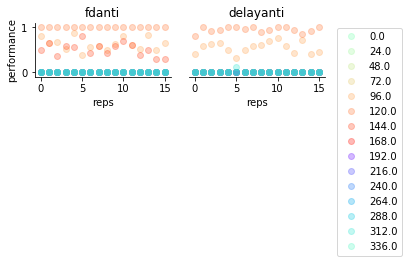

In [113]:
fig = plt.figure(figsize=(3*len(task_list),3),tight_layout=True,facecolor='white')
for rule_i in range(len(task_list)):
    ax = plt.subplot(1,len(task_list),rule_i+1)
    for theta_i in range(len(bins)-1):
        c = (180*(np.pi + bins[theta_i])/np.pi)%360
        plt.plot(perf_tmp[rule_i,:,theta_i],'o',c = cmap(c/360),alpha = .3,label = str(round(180*bins[theta_i]/np.pi,0)))
    plt.ylim([-.1,1.1])
    plt.title(task_list[rule_i])
    plt.xlabel('reps')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if rule_i==0:
        plt.ylabel('performance')
    else:
        ax.spines['left'].set_visible(False)
        plt.yticks([])
            
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [170]:
vmins = [-0.5, -0.5]
vmaxs = [+0.5, +0.5]
ticks = [[-0.5,0.5], [-0.5, 0.5]]

In [ ]:
plt.imshow(perfs_changes.T, cmap='coolwarm', aspect='auto',
                           interpolation='nearest', vmin=vmins[i], vmax=vmaxs[i])

In [19]:
def plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)
        hp = model.hp
        alpha = hp['dt']/hp['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hp, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
        fp_project = np.dot(sorted_fps,D_use)

        # runs jitters around fps
        stable = np.empty(len(fp_inds))
        for fp_ind in fp_inds:

            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, hp)
                jitter = np.dot(h_t,D_use)
                ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = .1)
                
            stable[fp_ind] = np.max(eig_decomps[fp_ind]['evals'].real**2+eig_decomps[fp_ind]['evals'].imag**2)

        stable_inds = np.where(stable<1)[0]
        ax.plot3D(fp_project[stable_inds,0],fp_project[stable_inds,1],fp_project[stable_inds,2],'o',
        c = c,markersize = 10, markerfacecolor = c,alpha = 1,linewidth = 5)

        unstable_inds = np.where(stable>1)[0]
        ax.plot3D(fp_project[unstable_inds,0],fp_project[unstable_inds,1],fp_project[unstable_inds,2],'o',
        c = c,markersize = 10, markerfacecolor = 'None',alpha = 1,linewidth = 5)
                
        #runs one state for n_steps starting from initial conditions
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hp)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 3)

In [28]:
def plot_N3D(ax, X, D, clist, linewidth = 1, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
#         ax.scatter3D(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],'^',c = c, linewidth = linewidth, alpha = alpha)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
#         ax.scatter3D(X_trial[0,0],X_trial[0,1],X_trial[0,2],'.',c = c, linewidth = linewidth, alpha = alpha)

In [40]:
%matplotlib

Using matplotlib backend: MacOSX


In [99]:
D_pca = {}
for rule in task_list:
    trial_order = npr.permutation(n_trials)
    X_rule = h_all_byrule[rule]
    X_flat = np.reshape(X_rule[:,trial_order,:],(-1,hp['n_rnn']))
    if len(X_use)==0:
        X_use = X_flat
    else:
        X_use = np.concatenate((X_use,X_flat),axis = 0)

pca = PCA(n_components = n_components)
fp_pca = pca.fit_transform(X_use)
D_pca['axes'] = pca.components_.T
D_pca['labels'] = ['pca_'+str(x+1) for x in range(n_components)]

In [13]:
# ########## TASK DYNAMICS ###########
# # from mpl_toolkits.mplot3d import Axes3D
# plt.rcParams.update({'font.size': 14})
# from mpl_toolkits import mplot3d
# from itertools import compress 
# from tools_lnd import gen_X_from_model_dir, gen_trials_from_model_dir, get_T_inds, vanilla_run_with_h0,comp_eig_decomp
# import numpy.random as npr
# from tools_lnd import make_h_all
# from sklearn.decomposition import PCA

# def compare_fp_lesions(m,D_use,lesion_cluster,task_list,color_by = 'stim'):

#     cmap_rainbow = plt.get_cmap('rainbow')

#     for ri in range(len(task_list)):
#         rule = task_list[ri]
#         trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#         B = np.shape(trial.y_loc)[1]
#         trial_set = range(0,B,int(B/10))

#         epoch_list = sorted(trial.epochs.items(), key=lambda x: x[1])
#         epoch_set = [epoch_list[x][0] for x in range(len(epoch_list))]

#         for trial_num in [0,]:##range(0,B,int(B/5))

#             fig = plt.figure(figsize=(6*2,5*len(epoch_set)),tight_layout=True,facecolor='white')
#             out_theta = 180*trial.y_loc[-1,trial_num]/np.pi

#             for plot_num in range(2*len(epoch_set)):

#                 epoch = epoch_set[int(np.floor(plot_num/2))]

#                 ax = plt.subplot(len(epoch_set),2,plot_num+1, projection='3d')
#                 w_color = .005
#                 ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
#                 ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
#                 ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

#                 if plot_num%2==0:
#                     ind_l = np.where(CA.labels == lesion_cluster)[0]
#                     lesion_units_list = [CA.ind_active[ind_l]][0]
#                     f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(t_set[0])+'.0.npz')
#                     tit_lesion = 'LESION_'+str(lesion_cluster)
#                 else:
#                     lesion_units_list = []
#                     f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[0])+'.0.npz')
#                     tit_lesion = 'NO_LESION'

#                 fp_struct = np.load(f)
#                 sorted_fps = fp_struct['xstar']
#                 fp_inds = range(len(sorted_fps))
#                 eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])

#                 _,x = gen_X_from_model_dir(m,trial)
#                 T_inds = get_T_inds(trial,epoch)
#                 x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

#                 if color_by == 'stim1':
#                     c_list = np.min(trial.stim_locs,axis=1)
#                 else:
#                     c_list = trial.y_loc[-1,:]

#                 plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,
#                                          sorted_fps,fp_inds,eig_decomps,rand_step_coef = 0.1, 
#                                          al = 1, linestyle = '-', n_steps = 60,n_jit = 0,
#                                          c = cmap_rainbow(out_theta/360))

#                 plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 3, 
#                          linestyle = '-',alpha = .3)

#                 ax.set_xlabel(axes_labels[0],fontsize = 14)
#                 ax.set_ylabel(axes_labels[1],fontsize = 14)
#                 ax.set_zlabel(axes_labels[2],fontsize = 14)
#                 ax.spines['top'].set_visible(False)
#                 ax.spines['right'].set_visible(False)
#                 tit = tit_lesion+'_'+rule+'_'+epoch+'_'+str(out_theta)
#                 plt.title(tit,fontsize = 14)

#     #                 ax.view_init(-130, 67)

#             save_dir = os.path.join(figpath,'lesion_fps'+str(lesion_cluster),rule,axes_labels[0][:3])

#             if not os.path.exists(save_dir):
#                 os.makedirs(save_dir)
#             figname = rule+'_'+epoch+'_'+str(out_theta)
#             plt.savefig(os.path.join(save_dir,figname+'.pdf'))
#             plt.savefig(os.path.join(save_dir,figname+'.png'))
#             plt.show()

In [35]:
def compare_fp_lesions(m,lesion_cluster,task_list,color_by = 'stim',n_components = 3):
    
    cmap_rainbow = plt.get_cmap('rainbow')
    h_all_byepoch, h_all_byrule = make_h_all(m)

    for ri in range(len(task_list)):
        rule = task_list[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        B = np.shape(trial.y_loc)[1]
        trial_set = range(0,B,int(B/10))

        D_pca = {}
        X_rule = h_all_byrule[rule]
        X_flat = np.reshape(X_rule,(-1,hp['n_rnn']))

        pca = PCA(n_components = n_components)
        fp_pca = pca.fit_transform(X_flat)
        D_pca['axes'] = pca.components_.T
        D_pca['labels'] = ['pca_'+str(x+1) for x in range(n_components)]

        D_use = D_pca['axes']
        axes_labels = D_pca['labels']

        epoch_list = sorted(trial.epochs.items(), key=lambda x: x[1])
        epoch_set = [epoch_list[x][0] for x in range(len(epoch_list))]

        for trial_num in [0,]:##range(0,B,int(B/5))

            fig = plt.figure(figsize=(6*2,5*len(epoch_set)),tight_layout=True,facecolor='white')
            out_theta = int(180*trial.y_loc[-1,trial_num]/np.pi)

            for plot_num in range(2*len(epoch_set)):

                epoch = epoch_set[int(np.floor(plot_num/2))]

                ax = plt.subplot(len(epoch_set),2,plot_num+1, projection='3d')
                w_color = .005
                ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
                ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
                ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

                if plot_num%2==0:
                    ind_l = np.where(CA.labels == lesion_cluster)[0]
                    lesion_units_list = [CA.ind_active[ind_l]][0]
                    f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(out_theta)+'.0.npz')
                    tit_lesion = 'LESION_'+str(lesion_cluster)
                else:
                    lesion_units_list = []
                    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(out_theta)+'.0.npz')
                    tit_lesion = 'NO_LESION'
                    
                fp_struct = np.load(f)
                sorted_fps = fp_struct['xstar']
                fp_inds = range(len(sorted_fps))
                eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])

                _,x = gen_X_from_model_dir(m,trial)
                T_inds = get_T_inds(trial,epoch)
                x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

                if color_by == 'stim1':
                    c_list = np.min(trial.stim_locs,axis=1)
                else:
                    c_list = trial.y_loc[-1,:]

                plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,
                                         sorted_fps,fp_inds,eig_decomps,rand_step_coef = 0.1, 
                                         al = 1, linestyle = '-', n_steps = 60,n_jit = 0,
                                         c = cmap_rainbow(out_theta/360))

                plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 3, 
                         linestyle = '-',alpha = .3)

                ax.set_xlabel(axes_labels[0],fontsize = 14)
                ax.set_ylabel(axes_labels[1],fontsize = 14)
                ax.set_zlabel(axes_labels[2],fontsize = 14)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                tit = tit_lesion+'_'+rule+'_'+epoch+'_'+str(out_theta)
                plt.title(tit,fontsize = 14)

    #                 ax.view_init(-130, 67)

            figname = rule+'_'+epoch+'_'+str(out_theta)
            if not os.path.exists(os.path.join(save_dir,'vis_fp_lesion')):
                os.makedirs(os.path.join(save_dir,'vis_fp_lesion'))
            plt.savefig(os.path.join(save_dir,'vis_fp_lesion',figname+'.pdf'))

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

IOError: [Errno 2] No such file or directory: u'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaydm1/fix1_180.0.npz'

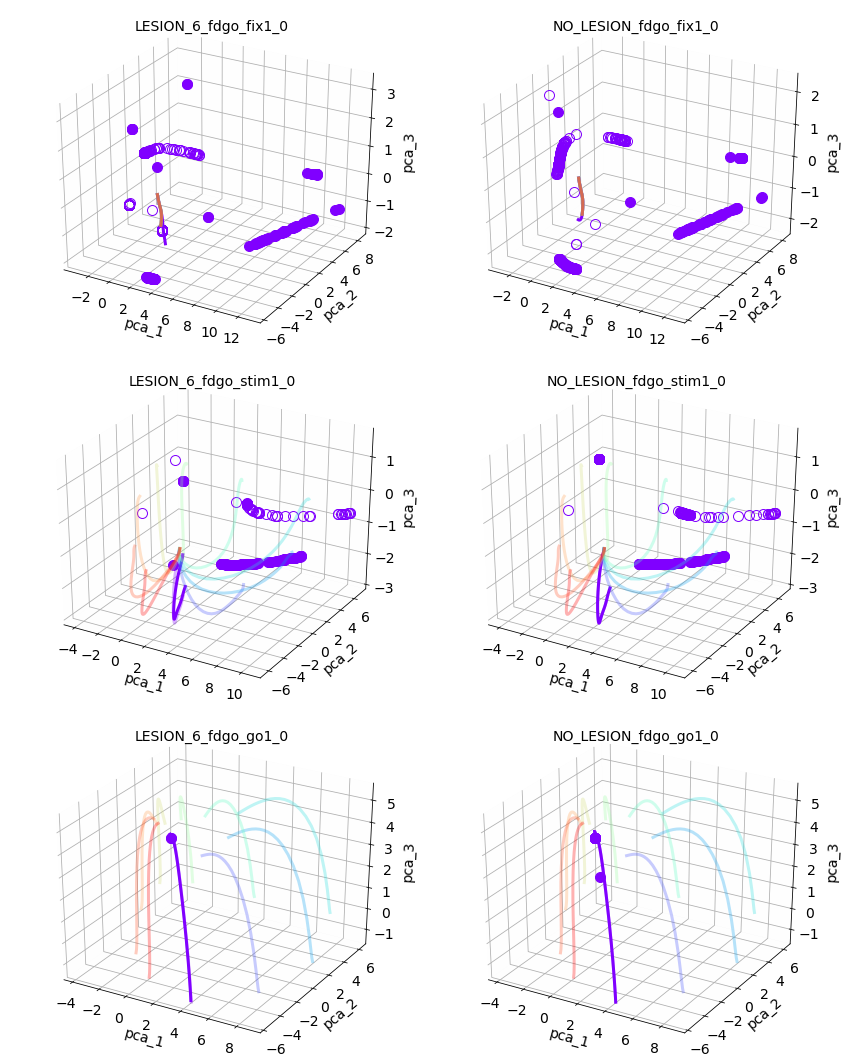

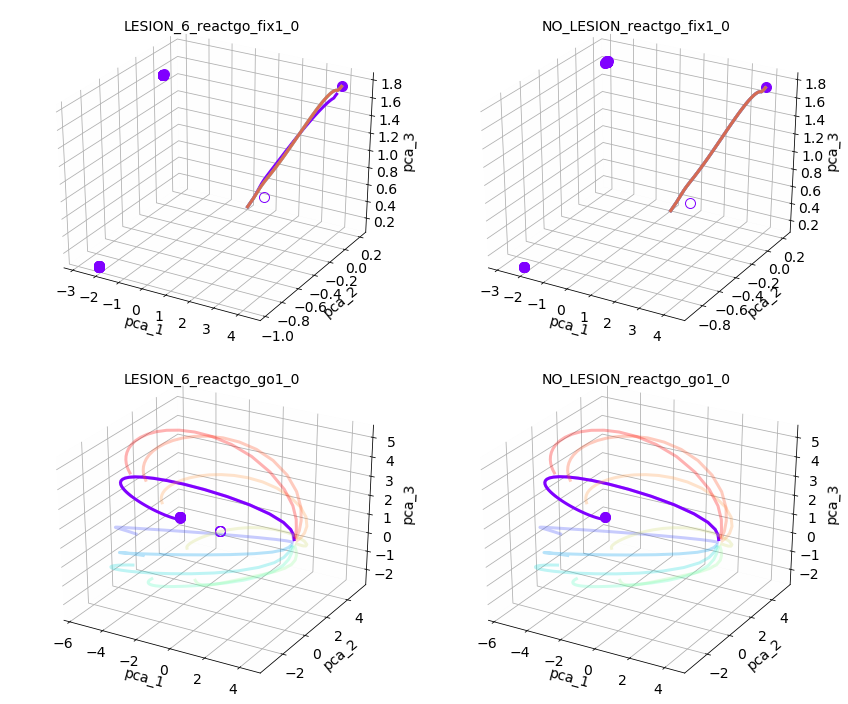

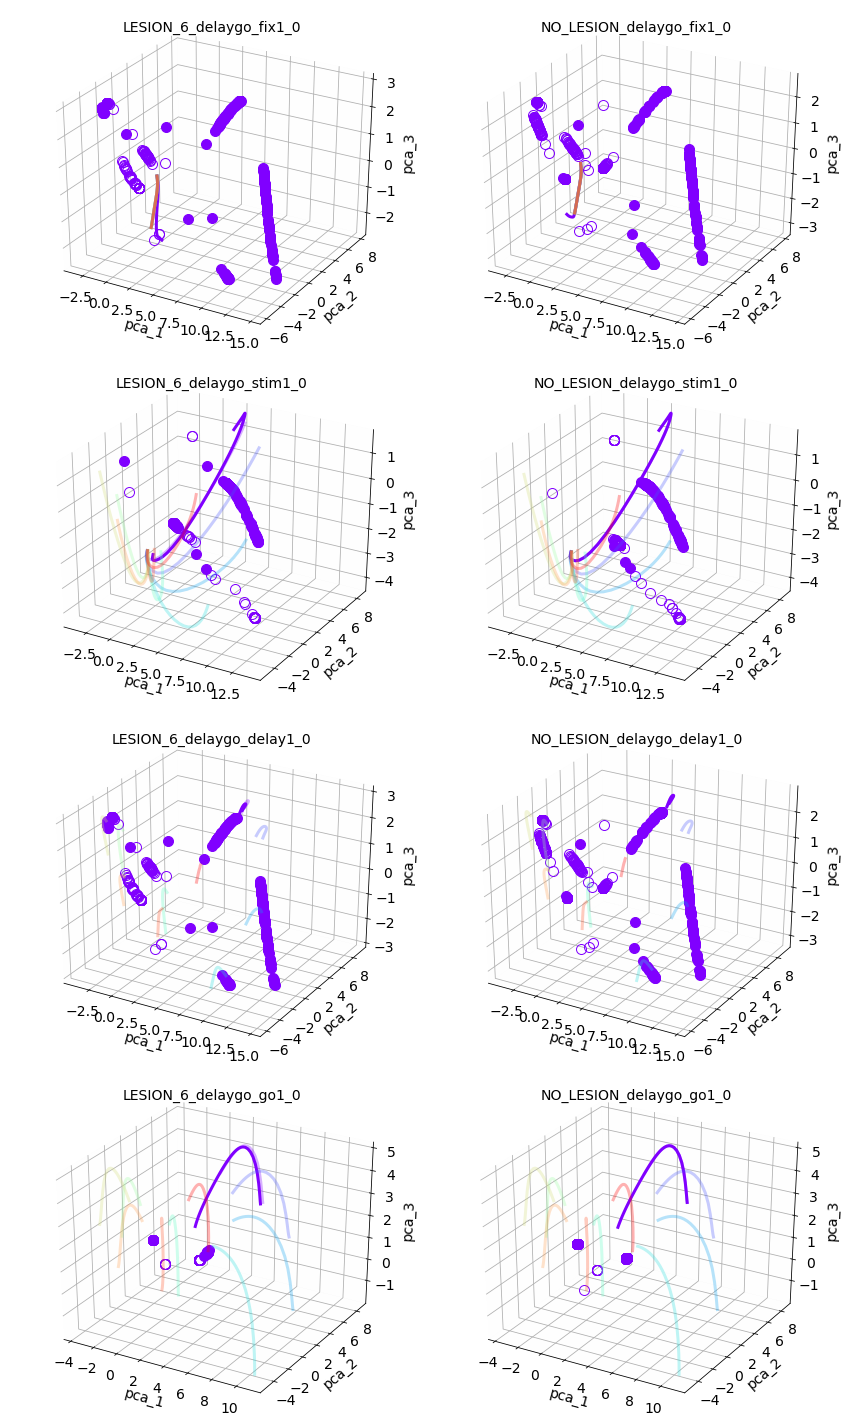

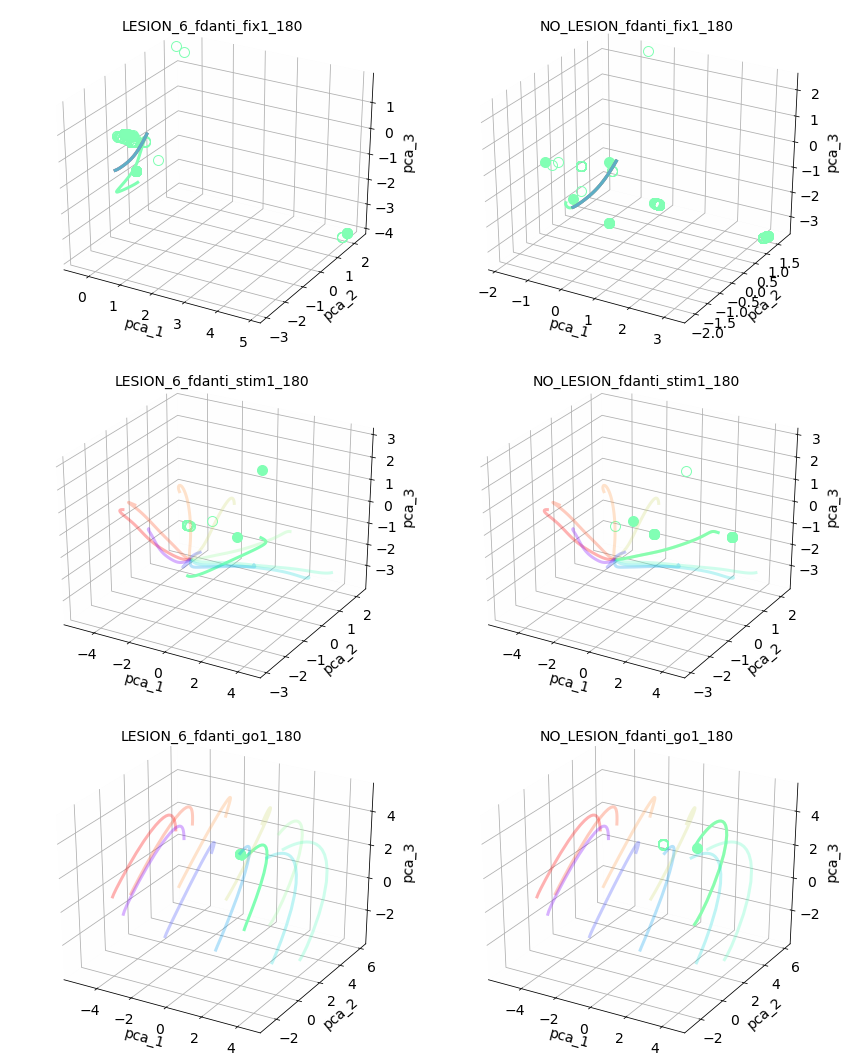

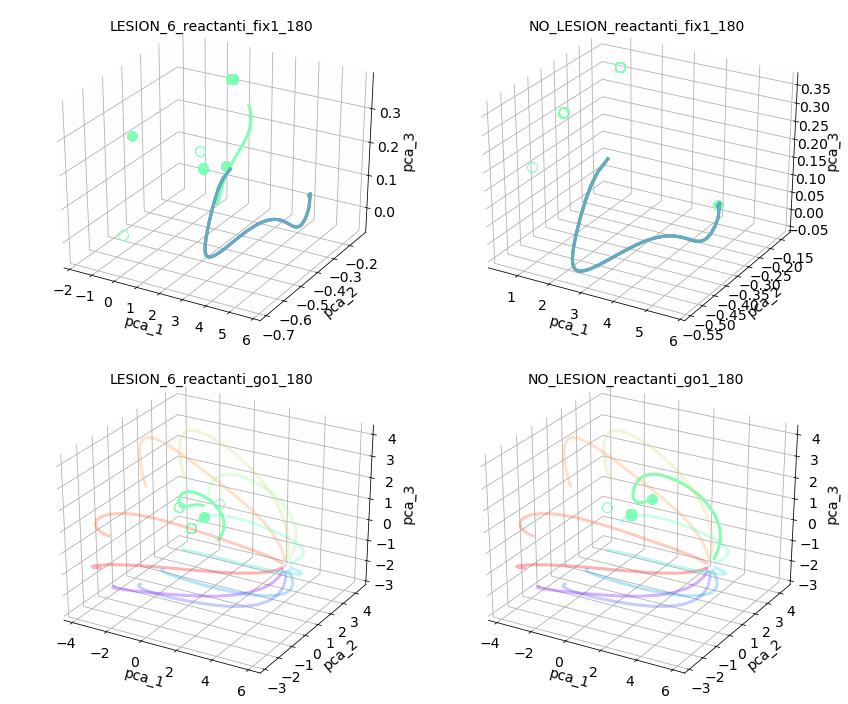

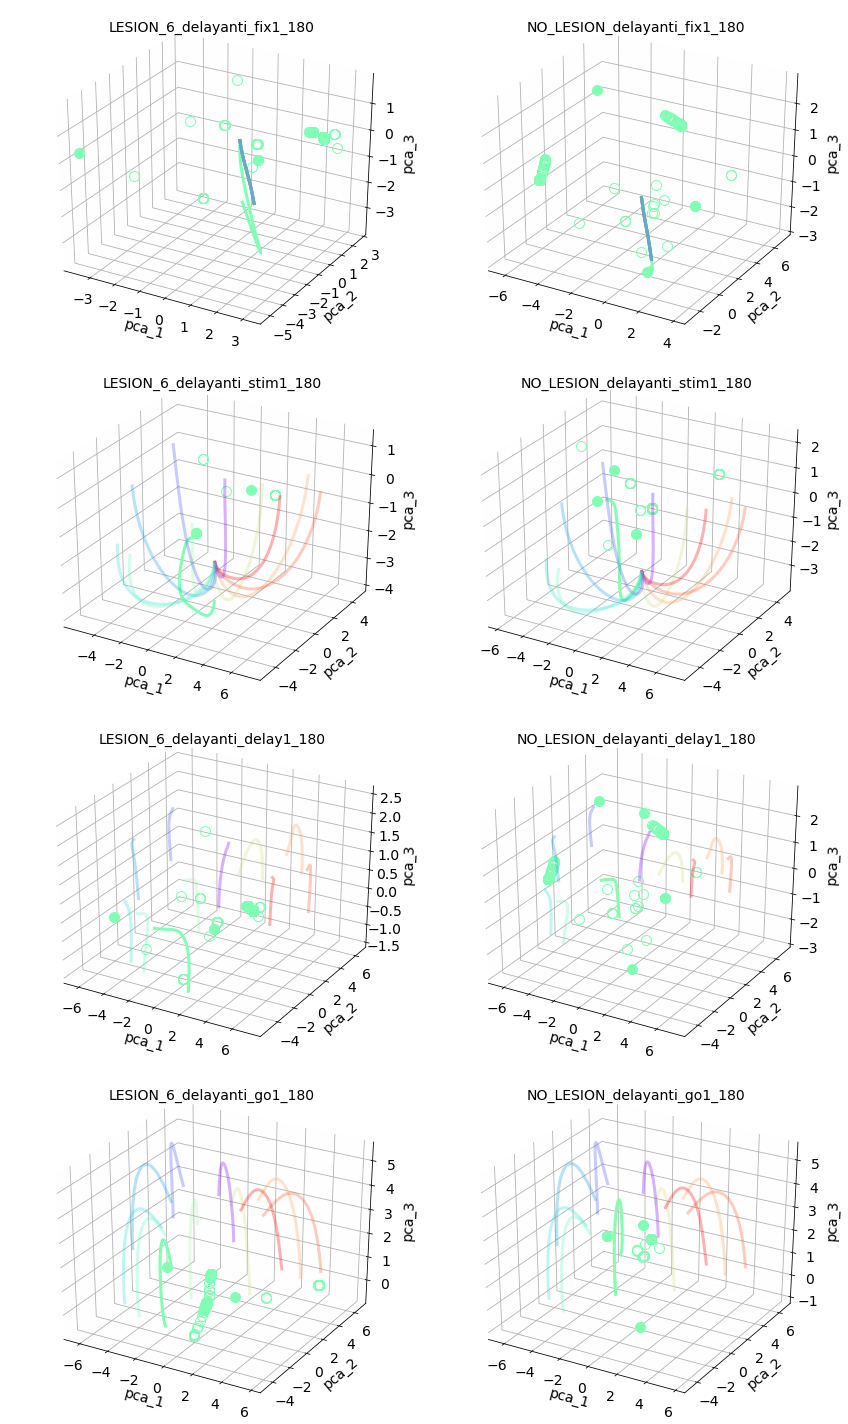

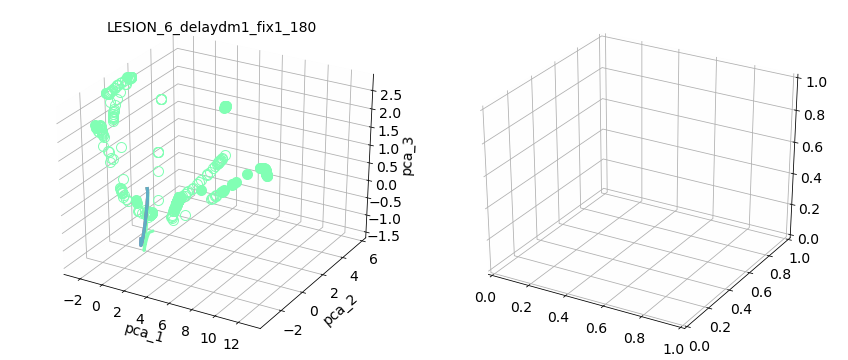

In [36]:
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
from itertools import compress 
from tools_lnd import gen_X_from_model_dir, gen_trials_from_model_dir, get_T_inds, vanilla_run_with_h0,comp_eig_decomp
import numpy.random as npr
from tools_lnd import make_h_all
from sklearn.decomposition import PCA

lesion_cluster = 6
task_list = ['fdanti',]
color_by = 'stim'

compare_fp_lesions(m,cluster,hp['rule_trains'])

In [ ]:
if plot_num%2==0:
    ind_l = np.where(CA.labels == lesion_cluster)[0]
    lesion_units_list = [CA.ind_active[ind_l]][0]
    f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(out_theta)+'.0.npz')
    tit_lesion = 'LESION_'+str(lesion_cluster)
else:
    lesion_units_list = []
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(out_theta)+'.0.npz')
    tit_lesion = 'NO_LESION'

fp_struct = np.load(f)
sorted_fps = fp_struct['xstar']
fp_inds = range(len(sorted_fps))
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])

_,x = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch)
x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

In [152]:
cmap = plt.get_cmap('rainbow')
c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
c = cmap(c_list[t_num]/(2*np.pi))
FP_proj = np.dot(sorted_fps,D_use)

epoch = 'fix1'

trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)

T_inds = get_T_inds(trial,epoch)

_, h_full = gen_X_from_model_dir(m,trial,d = [])

h0 = h_full[:,t_num,T_inds[0]]
x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],len(T_inds),1)

# s_set = [24,15,29]#delaygo
s_set = [3,22,24]#fdgo
color_set = ['r', 'm', 'b']
t_num = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,epoch+'_'+str(t_num)+'.0.npz')
fp_struct = np.load(f)
fp_inds = np.argsort([LA.norm(s - h_tf) for s in fp_struct['xstar']])
sorted_fps = fp_struct['xstar']
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])

fig = plt.figure(figsize=(15,10),tight_layout=True,facecolor='white')
for si in range(len(s_set)):
    s = s_set[si]
    c = color_set[si]
    
    ax = plt.subplot(2,len(s_set),si+1+len(s_set))
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c=c,alpha = .5)
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title('q value : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = len(T_inds)
    ax = plt.subplot(2,len(s_set),si+1)
    
    plot_FP(sorted_fps, D_use.T, eig_decomps)
    
    plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c=c,markerfacecolor = 'None',markersize = 20)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#     #nonlinear system
    h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = .5)

#     #linear system
    h_t = h0[np.newaxis,:]
    for t in range(n_steps):
        del_h = h_t[-1,:] - fp_struct['xstar'][s,:]
        h1 = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h_t,h1[np.newaxis,:]),axis = 0)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[0,0],jitter[0,1],'x',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],':',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = 3,alpha = .5)
    
#     ax.xticks('None')
#     ax.yticks('None')
#     
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.ylim((-7,7))    
    plt.xlim((-4,4))
    plt.title(str(si) + ' : linear approx')
#     plt.axis('off')

plt.show()

[u'fdgo',
 u'reactgo',
 u'delaygo',
 u'fdanti',
 u'reactanti',
 u'delayanti',
 u'delaydm1',
 u'delaydm2',
 u'contextdelaydm1',
 u'contextdelaydm2',
 u'multidelaydm',
 u'dmsgo',
 u'dmsnogo',
 u'dmcgo',
 u'dmcnogo']

In [44]:
########## X STIM ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
from itertools import compress 
from tools_lnd import gen_X_from_model_dir, gen_trials_from_model_dir, get_T_inds, vanilla_run_with_h0, comp_eig_decomp
import numpy.random as npr


for offset in [360-108,]:#range(36,359,36):# 144
    fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
    t_set = [(180+offset)%360, (180+offset+36)%360]
    trial_num = [int(offset/4.5),int((8+offset/4.5)%80)]
    trial_set = range(0,80,8)

    rule_set = ['fdanti',]
    epoch_set = ['stim1','stim1']
    step_file = 'interp_stim'
    linestyle = ['-','-']
    n_interp = 20

    trial_str = '_'.join(str(round(t,2)) for t in t_set[:len(epoch_set)])
    rule_str = '_'.join(str(r) for r in rule_set)
    epoch_str = '_'.join(str(r) for r in epoch_set)

    cmap_grad = plt.get_cmap('plasma')
    cmap_rainbow = plt.get_cmap('rainbow')
    cmap_discrete = ['navy','gold']
    ax = fig.add_subplot(111, projection='3d')
    w_color = .005
    ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

    for ri in range(len(rule_set)):
        rule = rule_set[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        epoch = epoch_set[ri]

#         f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
        
        for ti in range(len(t_set)):
            if len(lesion_units_list)>0:
                f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(t_set[ti])+'.0.npz')
            else:
                f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ti])+'.0.npz')


            fp_struct = np.load(f)
            sorted_fps = fp_struct['xstar']
            fp_inds = range(len(sorted_fps))
            eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])


            _,x = gen_X_from_model_dir(m,trial)
            T_inds = get_T_inds(trial,epoch)
            x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

            #color by stim
            c_list = np.min(trial.stim_locs,axis=1)

            #color by target
        #     c_list = trial.y_loc[-1,:]


            plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num[ti],epoch,sorted_fps,fp_inds,eig_decomps,
                   rand_step_coef = 0.1, al = 1, linestyle = linestyle[ri], n_steps = 300, 
                       n_jit = 0,c = cmap_discrete[ti])#cmap_rainbow(c_list[trial_num[ti]]/(2*np.pi)))


        plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ti],alpha = .3)
    #     c_list = cmap_discrete[ri]
    #     highlight_trial = [trial_num[0],]
    #     plot_N3D(x_epoch[highlight_trial,:,:],D_use.T,c_list,linewidth = 3, linestyle = '-',alpha = 1)

        for step_i in range(n_interp):

            #a couple diff versions on filenames atm
    #         f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_step_'+str(step_i)#'_'+str(t_set[1])

#             f = rule_str+'_'+epoch_str+'_'+trial_str+'_step_'+str(step_i)
#             f = rule_str+'_'+'go1'+'_'+trial_str+'_step_'+str(step_i)
            f = rule_str+'_'+'stim1'+'_'+trial_str+'_step_'+str(step_i)

            filename = os.path.join(m,step_file,rule_str,f+'.npz')
            fp_struct = np.load(filename)
            step_fps = fp_struct['xstar']

            fp_project = np.dot(step_fps,D_use)
            ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))

    tit = 'X STIM '+rule_str+'_'+epoch_str+'_'+trial_str
    ax.text2D(0.05, 0.95, tit, transform=ax.transAxes)
    ax.set_xlabel(axes_label1,fontsize = 18)
    ax.set_ylabel(axes_label2,fontsize = 18)
    ax.set_zlabel(axes_label3,fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.view_init(27, 175)

    if len(lesion_units_list)>0:
        save_dir = os.path.join(figpath,step_file,'lesion_fps'+str(lesion_cluster),axes_label1)
    else:
        save_dir = os.path.join(figpath,step_file,axes_label1)
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    figname = tit+'_'+step_file+'_'+str(t_set[0])
    plt.savefig(os.path.join(save_dir,figname+'.pdf'))
    plt.savefig(os.path.join(save_dir,figname+'.png'))
    print(os.path.join(save_dir,figname+'.png'))
    plt.show()
#     pdb.set_trace()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

In [204]:
from scipy.spatial import distance
from numpy import linalg as LA
from tools_lnd import eigenspectrum_axes
def dst_to_h(h,sorted_fps):
    X = np.squeeze(sorted_fps).astype(np.float64)
    dst = np.zeros((np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
            dst[xi] = distance.euclidean(h, X[xi,:])
    return dst

def proximate_fp(h,fps):
    if len(fps)==1:
        proximate_fps = 0
    else:
        sorted_fps_list = np.argsort(dst_to_h(h,fps))
        proximate_fps = sorted_fps_list[0]
    return proximate_fps

In [24]:
def FP_PC_axes(ax):

    ax.set_xlabel('FP PC1',fontsize = 20)
    ax.set_ylabel('FP PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 

In [186]:
def PC_axes(ax):

    ax.set_xlabel('h PC1',fontsize = 20)
    ax.set_ylabel('h PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [206]:
lesion_cluster = 6

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

KeyboardInterrupt: 

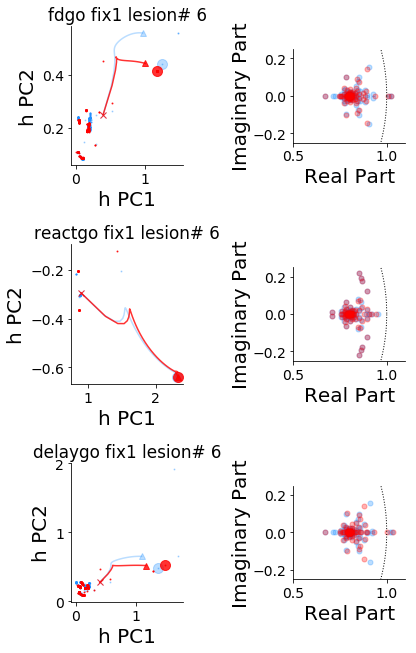

In [207]:
cmap_grad = plt.get_cmap('rainbow')
task_list = hp['rule_trains'][:-2]
n_tasks = len(task_list)
epoch = 'fix1'
ti = 0

fig = plt.figure(figsize=(3*2,3*n_tasks),tight_layout=True,facecolor='white')

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    B = np.shape(trial.y_loc)[1]
    trial_set = range(0,B,int(B/10))
    
    
    T_inds = get_T_inds(trial,epoch)
    out_theta = int(180*trial.y_loc[-1,ti]/np.pi)
    
    
    
    for subplot_i in range(2):

        if subplot_i>0:
            ind_l = np.where(CA.labels == lesion_cluster)[0]
            lesion_units_list = [CA.ind_active[ind_l]][0]
            f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(out_theta)+'.0.npz')
            tit_lesion = 'LESION_'+str(lesion_cluster)
            a_plot = .8
            fp_color = 'r'
        else:
            lesion_units_list = []
            f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(out_theta)+'.0.npz')
            
            if not os.path.isfile(f):
                nonzero_stim = trial.stim_locs[0,:]<100
                stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[ti,nonzero_stim])
                filename = epoch+'_trial'+str(ti)+'_x'+stim_names+'_y'+str(out_theta)+'.npz'
                f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)
                
            tit_lesion = 'NO_LESION'
            a_plot = .3
            fp_color = 'dodgerblue'

        fp_struct = np.load(f)
        xstar = fp_struct['xstar']
        
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units_list)

        if subplot_i==0:
            D_fp = {}
            pca = PCA(n_components = n_components)
            X_flat = np.reshape(h_all[:,ti,T_inds],(-1,hp['n_rnn']))
#             X_flat = xstar
            fp_pca = pca.fit_transform(X_flat)
            D_fp['axes'] = pca.components_.T
            D_fp['labels'] = ['PCA_'+str(x+1) for x in range(n_components)]
        
            D_use = D_fp['axes']
            axes_labels = D_fp['labels']

        h_ind = h_all[:,ti,T_inds[-1]]
        proximate_fps = proximate_fp(h_ind,xstar)
        fp_num = proximate_fps
        evals, _ = LA.eig(fp_struct['J_xstar'][fp_num,:,:]) 
        
        ax1 = fig.add_subplot(n_tasks,2,1+ri*2)
        D_h = np.dot(D_use.T,h_all[:,ti,T_inds])
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_use.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_use.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax2 = fig.add_subplot(n_tasks,2,2+ri*2)
        ax2.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
#         ax2.plot(evals.real,evals.imag,'.',c = fp_color,alpha = .3)
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax2.plot(xs, ys,':k',linewidth = 1)
    ax2.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.5,1.1))
    plt.ylim((-.25,.25))
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax2)
    ax2.set_aspect('equal')  
    PC_axes(ax1) 
    ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))
    # ax1.set_aspect('equal') 
plt.show()

In [25]:
def load_proximal_fp_from_f(f,h):
    fp_struct = np.load(f)
    xstar = fp_struct['xstar']
    
    proximate_fps = proximate_fp(h,xstar)
    fp_num = proximate_fps
    evals, _ = LA.eig(fp_struct['J_xstar'][fp_num,:,:])
    
    return xstar, fp_struct['J_xstar'], fp_num, evals

In [152]:
class rnn_obj(object):

    default_hps = {
        'tf_dtype': 'float32',
        'random_seed': model_n,
        'rnn_cell_feed_dict': {},
    }

    def __init__(self, rnn_cell, sess,
        random_seed=default_hps['random_seed'],
        tf_dtype=default_hps['tf_dtype'],
        rnn_cell_feed_dict=default_hps['rnn_cell_feed_dict']):
        
        self.rnn_cell = rnn_cell
        self.rnn_cell_feed_dict = rnn_cell_feed_dict
        self.session = sess
        self.tf_dtype = getattr(tf, tf_dtype)
        
    def _grab_RNN(self, initial_states, inputs):

        x = tf.Variable(initial_states, dtype=self.tf_dtype)
        x_rnncell = x

        inputs_tf = tf.constant(inputs, dtype=self.tf_dtype)

        output, F_rnncell = self.rnn_cell(inputs_tf, x_rnncell)
        F = F_rnncell
        
        init = tf.variables_initializer(var_list=[x,])
        self.session.run(init)

        return x, F

In [159]:
from tensorflow.python.ops import parallel_for as pfor
import absl

def calc_Jac(sess,rnn_o,feed_dict,states,inputs):
    x_tf, F_tf = rnn_o._grab_RNN(states, inputs)
    try:
       dFdx_tf = pfor.batch_jacobian(F_tf, x_tf)
    except absl.flags._exceptions.UnparsedFlagAccessError:
       dFdx_tf = pfor.batch_jacobian(F_tf, x_tf, use_pfor=False)
    dFdx_np = sess.run(dFdx_tf)
    return dFdx_np

def calc_relevant_jacobian(m,fp_struct,fp_num):
    
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()

        rnn_o_hps = {}
        rnn_o = []
        rnn_o = rnn_obj(model.cell,sess, **rnn_o_hps) 

        state = fp_struct['xstar'][fp_num][np.newaxis,:]
        inputs = fp_struct['inputs'][fp_num][np.newaxis,:]

        dFdx = calc_Jac(sess,rnn_o,feed_dict,state,inputs)
    return dFdx

In [184]:
len([])

0

In [207]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from tools_lnd import make_dendro

lesion_cluster = 8
epoch = 'go1'
ti = 0
task_list = hparams['rule_trains']

method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
save_dir = os.path.join(m,lesion_folder)
if not os.path.isfile(save_dir) :
    make_dendro(m)
    
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
D = cluster_var['D']
CA = cluster_var['CA']
clusters = cluster_var['clusters']
lesion_units_list = cluster_var['lesion_units_list']

lesion_effect[epoch] = {}

lesion_effect[epoch]['task_list'] = task_list
lesion_effect[epoch]['J_corr']= np.zeros(len(task_list))
lesion_effect[epoch]['h_corr']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_h_start']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_h_end']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_fp']= np.zeros(len(task_list))

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    
    if  epoch in trial.epochs.keys():
        
        T_inds = get_T_inds(trial,epoch)
        out_theta = int(180*trial.y_loc[-1,ti]/np.pi)

        #LESION
        lesion_units=lesion_units_list[lesion_cluster]
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(lesion_cluster),rule,epoch+'_'+str(out_theta)+'.0.npz')
        
        fp_struct = np.load(f)
        
        #identify relevant fp
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units)
        h_epoch_lesion = h_all[:,ti,T_inds]
        proximate_fps = proximate_fp(h_epoch_lesion[:,-1],fp_struct['xstar'])
        fp_num = proximate_fps
        xstar_lesion = fp_struct['xstar'][fp_num,:]
        J_xstar_lesion = calc_relevant_jacobian(m,fp_struct,fp_num)
        
        #NO LESION
        lesion_units = []
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_'+str(out_theta)+'.0.npz')
        
#         if not os.path.isfile(f):
#             nonzero_stim = trial.stim_locs[0,:]<100
#             stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[ti,nonzero_stim])
#             filename = epoch+'_trial'+str(ti)+'_x'+stim_names+'_y'+str(out_theta)+'.npz'
#             f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)

        fp_struct = np.load(f)
    
        #identify relevant fp
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units)
        h_epoch_full = h_all[:,ti,T_inds]
        proximate_fps = proximate_fp(h_epoch_full[:,-1],fp_struct['xstar'])
        fp_num = proximate_fps
        xstar_full = fp_struct['xstar'][fp_num,:]
        J_xstar_full = calc_relevant_jacobian(m,fp_struct,fp_num)

        #correlation of Jacobian around FP
        J_full = J_xstar_full[0]
        J_lesion = J_xstar_lesion[0]
        pearson = np.corrcoef(J_full.flatten(),J_lesion.flatten())
        lesion_effect[epoch]['J_corr'][ri] = pearson[1,0]

        #correlation of hidden state traj
        pearson = np.corrcoef(h_epoch_full.flatten(),h_epoch_lesion.flatten())
        lesion_effect[epoch]['h_corr'][ri] = pearson[1,0]

        #dist of hidden state traj
        dst_h = [LA.norm(h_epoch_full[:,x] - h_epoch_lesion[:,x]) for x in range(np.shape(h_epoch_lesion)[1])]
        lesion_effect[epoch]['dst_h_start'][ri] = dst_h[0]
        lesion_effect[epoch]['dst_h_end'][ri] = dst_h[-1]

        #dist of proximal fp
        lesion_effect[epoch]['dst_fp'][ri] = LA.norm(xstar_full - xstar_lesion)
        
    else:
        lesion_effect[epoch]['J_corr'][ri] = np.NaN
        lesion_effect[epoch]['h_corr'][ri] = np.NaN
        lesion_effect[epoch]['dst_h_start'][ri] = np.NaN
        lesion_effect[epoch]['dst_h_end'][ri] = np.NaN
        lesion_effect[epoch]['dst_fp'][ri] = np.NaN
        
# save cluster variables
lesion_effect_var = {epoch:lesion_effect[epoch]}
np.savez(os.path.join(save_dir,epoch+'_lesion_effect_var.npz'),**lesion_effect_var)
    

ImportError: cannot import name make_dendro

In [202]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','cluster-lesions','figs')
if not os.path.exists(figpath):
    os.makedirs(figpath)
save_dir = os.path.join(figpath,'lesion '+str(lesion_cluster))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

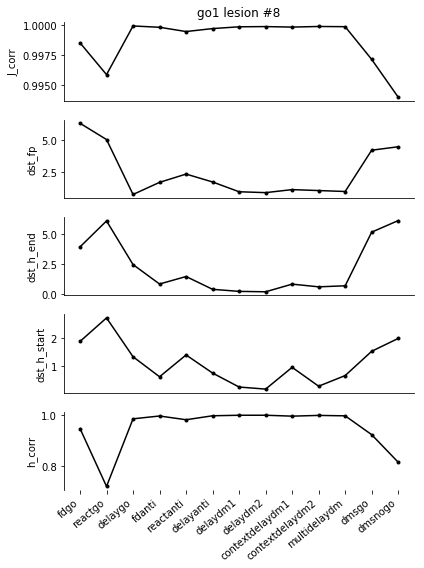

In [206]:
fig = plt.figure(figsize=(6,8),tight_layout=True,facecolor='white')
nc = len(lesion_effect[epoch].keys())-1
nr = 1

keys_list = np.sort(lesion_effect[epoch].keys())

for col_i in range(nc):
    ax1 = plt.subplot(nc,1,col_i+1)
    key = keys_list[col_i]
    plt.plot(lesion_effect[epoch][key][:-2],'.-k')
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.ylabel(key)

    if col_i==0:
        plt.title(epoch+' lesion #'+str(lesion_cluster))
        ax1.set_xticks([])
    elif col_i==(nc-1):
        ax1.spines['bottom'].set_visible(False)
        task_list = lesion_effect[epoch]['task_list']
        ax1.set_xticks(range(len(task_list[:-2])))
        ax1.set_xticklabels(task_list[:-2],rotation = 40,ha='right')
    else:
        ax1.set_xticks([])

figname = epoch+'_fp_lesion_stats'
plt.savefig(os.path.join(save_dir,figname+'.pdf'))

In [190]:
lesion_effect[epoch]['task_list']

[u'fdgo',
 u'reactgo',
 u'delaygo',
 u'fdanti',
 u'reactanti',
 u'delayanti',
 u'delaydm1',
 u'delaydm2',
 u'contextdelaydm1',
 u'contextdelaydm2',
 u'multidelaydm',
 u'dmsgo',
 u'dmsnogo',
 u'dmcgo',
 u'dmcnogo']